LDA : Linear Discriminant Analysis

In [9]:

# %% [markdown]
# # ML Baseline Paris - Application des 7 Méthodes du Cours
# 
# **Objectif** : Tester les 7 méthodes sur le dataset Paris pré-traité
# 
# Les données sont déjà :
# - Nettoyées et normalisées
# - Encodées (one-hot, amenities, etc.)
# - Avec target_class créée (quartiles de prix)

# %%
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées")

# %% [markdown]
# ## 1. Chargement des Données (Déjà pré-traitées)

# %%
# Chargement du dataset final (déjà normalisé et encodé)
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f"📊 Dataset chargé : {df.shape}")
print(f"\n🔍 Aperçu des colonnes :")
print(df.columns.tolist())

# Vérification target
if 'target_class' in df.columns:
    print(f"\n✅ Target trouvée : {df['target_class'].nunique()} classes")
    print(df['target_class'].value_counts().sort_index())
else:
    print("⚠️ Attention : 'target_class' non trouvée dans le dataset")

# Aperçu
print(f"\n📋 Aperçu des 5 premières lignes :")
print(df.head())

# %% [markdown]
# ## 2. Préparation X/y et Train/Test Split

# %%
print("=" * 60)
print("PRÉPARATION : Séparation X/y et Train/Test Split")
print("=" * 60)

# Séparation X (features) et y (target)
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])

# Supprimer city_label si présent
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nFeatures (X) : {X.shape[1]} colonnes")
print(f"Target (y) : {len(y)} valeurs")
print(f"\nDistribution des classes :")
print(y.value_counts().sort_index())

# Split 80/20 stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n✅ Split effectué :")
print(f"  Train : {X_train.shape}")
print(f"  Test  : {X_test.shape}")
print(f"\nDistribution Train :")
print(y_train.value_counts().sort_index())
print(f"\nDistribution Test :")
print(y_test.value_counts().sort_index())

# %% [markdown]


✅ Bibliothèques importées
📊 Dataset chargé : (73111, 30)

🔍 Aperçu des colonnes :
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

✅ Target trouvée : 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

📋 Aperçu des 5 premières lignes :
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0  

Let's go


MÉTHODE 3 : LDA (Linear Discriminant Analysis)
Dimensions réduites : 27 → 3
Variance expliquée : [0.90665568 0.08597618 0.00736814]


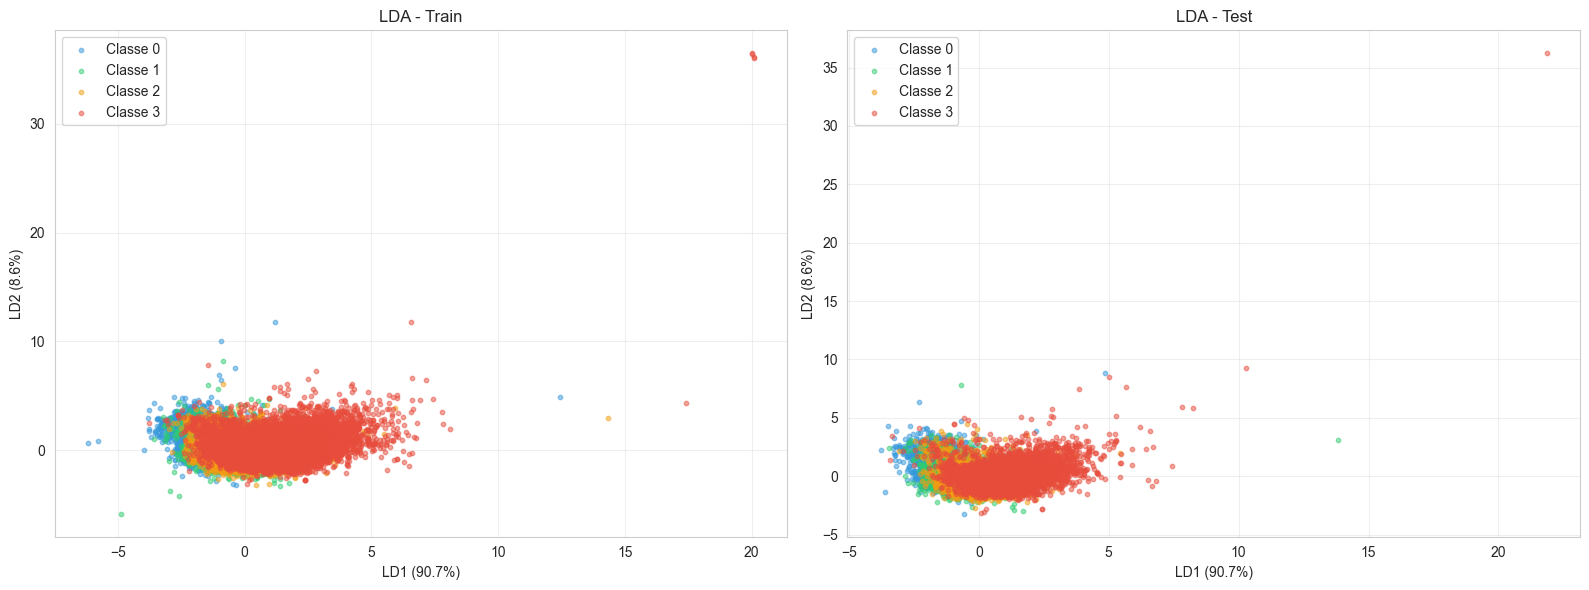

✅ LDA trouve les axes discriminants


In [8]:
# %% [markdown]
# ## 5. MÉTHODE 3 : LDA - Linear Discriminant Analysis

colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

# %%
print("\n" + "=" * 60)
print("MÉTHODE 3 : LDA (Linear Discriminant Analysis)")
print("=" * 60)

# LDA (max 3 composantes pour 4 classes)
lda = LinearDiscriminantAnalysis(n_components=3)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print(f"Dimensions réduites : {X_train.shape[1]} → {X_train_lda.shape[1]}")
print(f"Variance expliquée : {lda.explained_variance_ratio_}")

# Visualisation 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (X_lda, y_set, title) in zip(axes, 
    [(X_train_lda, y_train, 'Train'), (X_test_lda, y_test, 'Test')]):
    
    for classe in range(4):
        mask = y_set == classe
        ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                  c=colors_class[classe], label=f'Classe {classe}', alpha=0.5, s=10)
    
    ax.set_title(f"LDA - {title}")
    ax.set_xlabel(f"LD1 ({lda.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"LD2 ({lda.explained_variance_ratio_[1]:.1%})")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ LDA trouve les axes discriminants")